In [1]:
# !pip install yfinance

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_teddynote import logging
logging.langsmith("CH21-2-MultiAGENT")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH21-2-MultiAGENT


# Multi Agent 

Supervision 기반 주식 종목 평가

In [4]:
import functools
import operator
from typing import Annotated, TypedDict, Sequence, Literal
from pydantic import BaseModel

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent

In [5]:
# 폰트 설정 
import matplotlib.pyplot as plt
import matplotlib as mpl

# MAC
plt.rcParams['font.family'] = 'AppleGothic'
mpl.rcParams['axes.unicode_minus'] = False

# WINDOWS
# plt.rcParams['font.family'] = 'Malgun Gothic'
# mpl.rcParams['axes.unicode_minus'] = False

## 1. Tool

### 인터넷 도구, 파이썬 코드 도구

In [6]:
tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

### 주식 도구

In [7]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

In [8]:
# 한국시간으로 데이터를 정확하게 가져오기 위한 확인 
import pytz
from datetime import datetime, timedelta

# 한국 시간 기준 현재 시각 확인
now_kst = datetime.now(pytz.timezone('Asia/Seoul'))
print(now_kst)

2025-04-01 16:18:40.128302+09:00


In [9]:
# 조회기간 
end_date = datetime.today()
start_date = end_date - timedelta(days=7)

# 삼성전자 시세 불러오기 (1시간 간격, 최근 7일)
ticker = yf.Ticker("005930.KS")
historical_prices = ticker.history(start=start_date, end=end_date, interval='1h')

print(historical_prices.tail())

                              Open     High      Low    Close   Volume  \
Datetime                                                                 
2025-04-01 10:00:00+09:00  58200.0  59100.0  58050.0  59100.0  2902054   
2025-04-01 11:00:00+09:00  59050.0  59600.0  59000.0  59300.0  1758858   
2025-04-01 12:00:00+09:00  59300.0  59400.0  58900.0  58950.0  1041837   
2025-04-01 13:00:00+09:00  58950.0  59300.0  58700.0  59100.0  1591998   
2025-04-01 14:00:00+09:00  59150.0  59300.0  58800.0  59000.0  1236448   

                           Dividends  Stock Splits  
Datetime                                            
2025-04-01 10:00:00+09:00        0.0           0.0  
2025-04-01 11:00:00+09:00        0.0           0.0  
2025-04-01 12:00:00+09:00        0.0           0.0  
2025-04-01 13:00:00+09:00        0.0           0.0  
2025-04-01 14:00:00+09:00        0.0           0.0  


In [10]:
# 최근 7일 시점의 날짜+시간과 종가 추출
last_close_history = historical_prices['Close']

# 날짜와 시간까지 포함된 딕셔너리 생성
last_5_hours_close_dict = {
    date.strftime('%Y-%m-%d %H:%M'): price for date, price in last_close_history.items()
}

# 결과 확인
last_close_history

Datetime
2025-03-26 09:00:00+09:00    60350.0
2025-03-26 10:00:00+09:00    61400.0
2025-03-26 11:00:00+09:00    61200.0
2025-03-26 12:00:00+09:00    61200.0
2025-03-26 13:00:00+09:00    61200.0
2025-03-26 14:00:00+09:00    61100.0
2025-03-27 09:00:00+09:00    61600.0
2025-03-27 10:00:00+09:00    61650.0
2025-03-27 11:00:00+09:00    61800.0
2025-03-27 12:00:00+09:00    61700.0
2025-03-27 13:00:00+09:00    61800.0
2025-03-27 14:00:00+09:00    61600.0
2025-03-28 09:00:00+09:00    60600.0
2025-03-28 10:00:00+09:00    60600.0
2025-03-28 11:00:00+09:00    60400.0
2025-03-28 12:00:00+09:00    60500.0
2025-03-28 13:00:00+09:00    60350.0
2025-03-28 14:00:00+09:00    60000.0
2025-03-31 09:00:00+09:00    58800.0
2025-03-31 10:00:00+09:00    58600.0
2025-03-31 11:00:00+09:00    58200.0
2025-03-31 12:00:00+09:00    58150.0
2025-03-31 13:00:00+09:00    58200.0
2025-03-31 14:00:00+09:00    58150.0
2025-04-01 09:00:00+09:00    58200.0
2025-04-01 10:00:00+09:00    59100.0
2025-04-01 11:00:00+09:00    

In [11]:
#재무 분석 툴 설정
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.
    
    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """
    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime('%Y-%m-%d %H:%M')
            summary[date_str] = {
                "총수익": format_number(data.get('TotalRevenue')),
                "영업이익": format_number(data.get('OperatingIncome')),
                "순이익": format_number(data.get('NetIncome')),
                "EBITDA": format_number(data.get('EBITDA')),
                "EPS(희석)": f"${data.get('DilutedEPS'):.2f}" if pd.notna(data.get('DilutedEPS')) else "N/A"
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(start=start_date, end=end_date, interval='1h')

    last_histroy_close = historical_prices['Close']
    last_histroy_close_dict = {date.strftime('%Y-%m-%d %H:%M'): price for date, price in last_histroy_close.items()}

    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str({
        "최근 종가": last_histroy_close_dict,
        "연간 재무제표 요약": format_financial_summary(annual_financials),
        "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
    })

## 2. Agent 
### Supervisor 에이전트 

options = ["FINISH"] + members

- Supervisor 에이전트의 역할은 다음 중 하나를 결정하는 것 
    - 다음 어떤 member가 일을 해야 할지 
    - 아니면 작업이 다 끝났는지 ("FINISH")
- 최종 선택지 = ["FINISH", "Researcher", "Stock_Analyzer", "Chart_Generator"]

In [12]:
today = datetime.today().strftime('%Y-%m-%d')

In [13]:
members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "Today is {today}."
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

options = ["FINISH"] + members

In [14]:
class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(
    today=today,
    options=str(options), 
    members=", ".join(members),
)

llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

### 하위 에이전트 

In [15]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [16]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next: str # 다음 어떤 노드로 이동할지 지시 (Supervisor 판단 결과) 

In [17]:
# Researcher
research_system_prompt = """
You are a helpful research analyst who is specialized in 
gathering valuable info for given stock.
"""

research_agent = create_react_agent(
    llm, 
    tools=[tavily_tool], 
    state_modifier=research_system_prompt,
)
research_node = functools.partial(
    agent_node, 
    agent=research_agent, 
    name="Researcher",
)

# Stock_Analyzer
stock_system_prompt="""
You are a helpful Stock and financial analyst. Never hallucinate the given metrics.
"""

stock_agent = create_react_agent(
    llm, 
    tools=[stock_analysis], 
    state_modifier=stock_system_prompt,
)
stock_node = functools.partial(
    agent_node, 
    agent=stock_agent, 
    name="Stock_Analyzer",
)

# Chart_Generator
chart_system_prompt="""
You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention.
"""
chart_agent = create_react_agent(
    llm, 
    tools=[python_repl_tool], 
    state_modifier=chart_system_prompt,
)
chart_node = functools.partial(
    agent_node, 
    agent=chart_agent, 
    name="Chart_Generator",
)

In [18]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

# 각 에이전트는 작업을 마친 후 반드시 supervisor에게 보고
for member in members:
    workflow.add_edge(member, "supervisor")

# Supervisor는 상태의 "next" 필드를 바탕으로 다음 노드 또는 종료 여부를 결정 
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END

workflow.add_conditional_edges(
    "supervisor", 
    lambda x: x["next"], 
    conditional_map)

workflow.add_edge(START, "supervisor")

graph = workflow.compile()

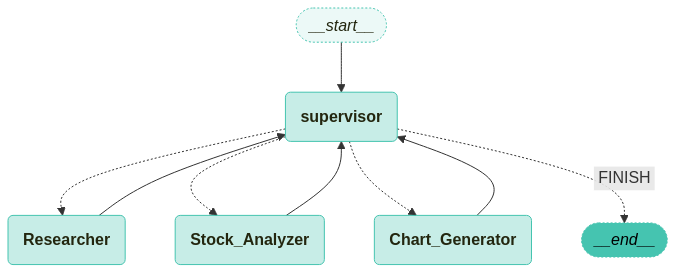

In [19]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(graph)

## 3. 실행

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='삼성전자 주식 매수 결정을 위한 정보를 요약해 드리겠습니다.\n\n1. **시장 전망**: 삼성전자의 주력 사업인 메모리 반도체 시장은 2023년 하반기에 중요한 변수로 작용할 것으로 보입니다. 과거 몇 년간 공급 과잉과 수요 감소가 있었으나, 향후 수요 회복이 예상되고 있습니다. [자세한 내용](https://blog.naver.com/banana0422_/223556491776)\n\n2. **재무 지표**:\n   - 배당수익률: 3.70%\n   - 영업이익률: 11.95%\n   - 순이익률: 12.00%\n   - ROE: 12.63%\n   이러한 지표들은 삼성전자가 안정적인 수익성을 유지하고 있음을 보여줍니다. [자세한 내용](http://comp.fnguide.com/SVO2/ASP/SVD_Main.asp?%s)\n\n3. **사업 부문**: 삼성전자는 크게 3가지 사업 부문(디바이스 익스피리언스, 디바이스 솔루션, 그리고 하드웨어)에 나뉘며, 이들 부문 모두에서 성장이 기대되고 있습니다. [자세한 내용](https://www.therich.io/community/articles/24036)\n\n4. **전문가 의견**: 최근 보고서에서는 삼성전자가 수요 회복의 초입 단계에 있으며, 매수 추천 의견이 나오고 있습니다. [자세한 내용](https://securities.miraeasset.com/bbs/board/message/list.do?categoryId=1800&searchType=2&searchStartYear=2023&searchStartMonth=05&searchStartDay=20&searchEndYear=2024&searchEndMonth=05&searchEndDay=19&listType=1&startId=09hdd~&startPage=51&curPage=54&

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/005930?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=005930&crumb=bUs%2FAHLjMxV
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/005930?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=005930&crumb=bUs%2FAHLjMxV
$005930: possibly delisted; no timezone found


{'Stock_Analyzer': {'messages': [HumanMessage(content='삼성전자(티커: 005930) 주식에 대한 최근 재무 분석 결과는 다음과 같습니다:\n\n1. **최근 종가**: 현재 주가는 확인할 수 없습니다.\n2. **연간 재무제표 요약**: 구체적인 수치가 제공되지 않았습니다.\n3. **분기별 재무제표 요약**: 구체적인 수치가 제공되지 않았습니다.\n\n현재 구체적인 재무 지표를 제공하지 못한 점 양해 부탁드립니다. 그러나, 이전에 제공된 정보들은 다음과 같은 결정을 내리는 데 도움이 될 수 있습니다:\n\n- **배당수익률**: 3.70%로 안정적인 배당을 제공하고 있어, 배당주 투자에 적합합니다.\n- **영업이익률과 순이익률**: 각각 11.95%와 12.00%로, 안정적인 수익성을 보여줍니다.\n- **ROE(자기자본이익률)**: 12.63%로, 자기자본에 대한 수익성이 높습니다.\n- **전문가 의견**: 수요 회복의 초입 단계에 있으며, 매수 추천 의견이 있습니다.\n\n이 외에도 시장 전망이 긍정적이고, 사업 부문에서의 성장이 기대되고 있습니다. 하지만, 주식 투자는 항상 리스크가 있으므로, 개인의 투자 목표와 리스크 수용 능력을 고려하여 신중히 결정하시기 바랍니다. 추가적인 정보나 분석이 필요하시면 말씀해 주세요.', additional_kwargs={}, response_metadata={}, name='Stock_Analyzer')]}}
----
{'supervisor': {'next': 'Chart_Generator'}}
----


Python REPL can execute arbitrary code. Use with caution.


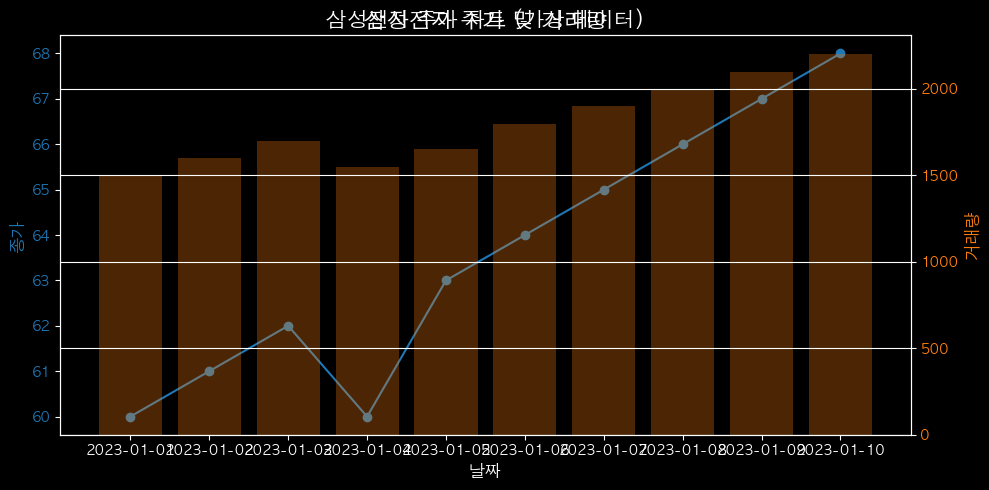

{'Chart_Generator': {'messages': [HumanMessage(content='삼성전자의 주가 차트와 거래량을 아래와 같이 시각화했습니다. 이 차트는 가상의 데이터를 기반으로 하여 작성되었으며, 주가는 파란색 선으로, 거래량은 주황색 막대그래프로 나타내어져 있습니다.\n\n![삼성전자 주가 및 거래량 차트](attachment://삼성전자주가차트.png) \n\n이 차트를 통해 삼성전자의 주가 동향과 거래량 변화를 시각적으로 확인할 수 있습니다. 추가적인 정보나 다른 차트가 필요하시면 말씀해 주세요.', additional_kwargs={}, response_metadata={}, name='Chart_Generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [20]:
for s in graph.stream({"messages": [HumanMessage(content="삼성전자 주식 매수 위한 의사 결정을 도와주세요")]}):
    if "__end__" not in s:
        print(s)
        print("----")

--------
** End of Documents **